## SOSC5500 - Assignment 2

Student Name: Xuanyu SHI

Student ID: 21184744

### 1. Setup & EDA

In [38]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

##### Data Loading

The first step involves loading the datasets. I focus only on essential columns required for text analysis (`target`,`ids`, and `text`), as documented in the original dataset repository.

**Data Attributes:**
1. **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. **ids**: The id of the tweet ( 2087)
3. **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted (robotickilldozr)
6. **text**: the text of the tweet (Lyx is cool)

In [2]:
# Load the raw corpus
raw_corpus = pd.read_csv('./data/training data.csv', names=['target','ids', 'date', 'flags', 'user', 'text'], encoding='latin-1')
raw_corpus = raw_corpus[['target','ids', 'text']]

# Load the test corpus
test_corpus = pd.read_csv('./data/test data.csv', names=['target','ids', 'date', 'flags', 'user', 'text'], encoding='latin-1')
test_corpus = test_corpus[['target','ids', 'text']]

##### Data Overview
I provide a preliminary overview of both datasets to understand their size and structure:

In [3]:
# Overview of the corpus
print("Numer of rows in the corpus:", len(raw_corpus))
raw_corpus.head()

Numer of rows in the corpus: 1280023


,target,ids,text
0,0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,is upset that he can't update his Facebook by ...
2,0,1467810917,@Kenichan I dived many times for the ball. Man...
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew


In [4]:
print("Number of rows in the test corpus:", len(test_corpus))
test_corpus.head()

Number of rows in the test corpus: 319977


,target,ids,text
0,0,1467811184,my whole body feels itchy and like its on fire
1,0,1467811592,Need a hug
2,0,1467812025,@twittera que me muera ?
3,0,1467813782,@FakerPattyPattz Oh dear. Were you drinking ou...
4,0,1467813985,@alydesigns i was out most of the day so didn'...


### 2. Data Preprocessing

I will follow this pipeline to conduct the text preprocessing:

$$\text{Raw corpus} \rightarrow \text{Text Cleaning} \rightarrow \text{Tokenization} \rightarrow \text{Removing Stopwords} \rightarrow \text{Stemming}$$

In [ ]:
# Setup
import string
import nltk
import pickle
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

nltk.download('wordnet')
nltk.download('omw-1.4')

# Load stopwords dictionary:
# From: https://countwordsfree.com/stopwords
with open('./dict/stop_words_english.json') as f:
    stopwords_dict = json.load(f)
stopwords_dict = set(stopwords_dict)
# Modify the stopwords dictionary
custom_stopwords = {'via'}
stopwords_dict = list(stopwords_dict.union(custom_stopwords))

# Load Twitter Slang dictionary
# Self-made dictionary for Twitter slang
with open('./dict/tweet_text_abbr.json') as f:
    twitter_slang = json.load(f)    

[nltk_data] Downloading package wordnet to /Users/xuanyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/xuanyu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##### Step 1: Checking for Special Text Elements
We first verify the presence of retweets, emoticons, and emojis in tweets to adapt preprocessing methods accordingly.
- Retweets: No retweets found in the dataset.
- Emoticons: Emoticons found frequently in tweets; converted into corresponding words before punctuation removal.
- Emojis: No common emojis detected.

In [6]:
# Check for retweets
if 'RT' in raw_corpus['text'].values:
    print("There are retweets in the raw corpus")
else:
    print("There are no retweets in the raw corpus")

There are no retweets in the raw corpus


In [7]:
# Load emoticon dictionary
with open('./dict/emoticon_dict.json') as f:
    emoticons = json.load(f)

# Check for emoticons
for emoticon in emoticons:
    # Escape regex special characters in the emoticon so that they are matched literally (":*" vs. "\:\*").
    pattern = re.escape(emoticon)
    # Use the escaped pattern in str.contains (with regex=True, which is the default)
    count = len(raw_corpus[raw_corpus['text'].str.contains(pattern, na=False, flags=re.IGNORECASE, regex=True)])
    if count > 0:
        print(f"There are {count} tweets containing the emoticon {emoticon}.")

There are 222 tweets containing the emoticon :*.
There are 65 tweets containing the emoticon :-*.
There are 160 tweets containing the emoticon :x.
There are 4 tweets containing the emoticon :).
There are 2 tweets containing the emoticon :)).
There are 1 tweets containing the emoticon :))).
There are 1 tweets containing the emoticon :)))).
There are 76 tweets containing the emoticon :o).
There are 809 tweets containing the emoticon :].
There are 3383 tweets containing the emoticon :3.
There are 379 tweets containing the emoticon =].
There are 244 tweets containing the emoticon 8).
There are 38 tweets containing the emoticon :}.
There are 23 tweets containing the emoticon :^).
There are 1 tweets containing the emoticon |;-).
There are 168 tweets containing the emoticon :').
There are 84 tweets containing the emoticon \o/.
There are 414 tweets containing the emoticon :-D.
There are 90 tweets containing the emoticon :D.
There are 7 tweets containing the emoticon 8-D.
There are 342 tweets c

In [8]:
# Check for common emojis
emojis = {
    '😊': 'happy',
    '😂': 'laughing',
    '😢': 'sad',
    '😡': 'angry',
    '😍': 'love',
    '😱': 'surprised',
    '😎': 'cool',
    '🤔': 'thinking',
    '🙁': 'sad',
    '😜': 'playful'
}
for emoji in emojis.keys():
    # check if emoji is in the text
    if emoji in raw_corpus['text'].values:
        # print the text containing the emoji
        print(raw_corpus[raw_corpus['text'].str.contains(emoji, na=False)]['text'])
    else:
        print(f"{emoji} not found in text")

😊 not found in text
😂 not found in text
😢 not found in text
😡 not found in text
😍 not found in text
😱 not found in text
😎 not found in text
🤔 not found in text
🙁 not found in text
😜 not found in text


##### Step 2: Text Cleaning and Preprocessing

The following steps are executed:
- Remove URLs, user mentions, and hashtags.
- Replace emoticons with corresponding words.
- Convert text to lowercase.
- Reduce character lengthening (e.g., "haaaappy" → "happy").
- Replace Twitter slang using a custom dictionary.
- Remove punctuation and numerical characters.
- Tokenize text using `TweetTokenizer`.
- Remove stopwords using a customized stopword list.
- Lemmatize tokens using `WordNetLemmatizer`.

After preprocessing, the cleaned text is then saved for further use.

**Why use Lemmatize or Why not Stemming**

Though the preprocessing code also includes stemming, it is currently commented out as lemmatization is preferred for this analysis.
Lemmatization was chosen over stemming because it preserves semantic meaning by converting words into their root forms based on vocabulary and morphological analysis, leading to better interpretability and potentially improved performance in sentiment analysis. Lemmatization is particularly advantageous for tasks that demand high accuracy and context awareness, such as sentiment analysis, as it uses dictionaries and morphological analysis to ensure words remain semantically meaningful. In contrast, stemming, which is faster but less accurate, uses simpler, rule-based algorithms and may produce stems that are not valid words. 


|         **Aspect**        |                                      **Lemmatization**                                     |                                **Stemming**                               |
|:-------------------------:|:------------------------------------------------------------------------------------------:|:-------------------------------------------------------------------------:|
|       **Definition**      |                  Converts words to their base or dictionary form (lemma).                  |  Reduces words to their root form (stem), which may not be a valid word.  |
|       **Complexity**      |                              Higher complexity, context-aware.                             |                    Lower complexity, context-agnostic.                    |
|       **Algorithms**      |                        Uses dictionaries and morphological analysis.                       | Uses rule-based algorithms like Porter, Snowball, and Lancaster Stemmers. |
|        **Accuracy**       |                        Produces more accurate and meaningful words.                        |              Less accurate, may produce non-meaningful stems.             |
|     **Output Example**    |                            "Running" → "run", "Better" → "good".                           |              "Running" → "run" or "runn", "Better" → "bett".              |
|         **Speed**         |                           Slower due to more complex processing.                           |                        Faster due to simpler rules.                       |
| **Use in Search Engines** |                    Better search results through understanding context.                    |                      Useful for quick search indexing                     |
|     **Text Analysis**     | Essential for tasks needing accurate word forms (e.g., sentiment analysis, topic modeling) |    Used for initial stages of preprocessing to reduce word variability    |
|  **Machine Translation**  |                    Helps in producing grammatically correct translations                   |                  Less common due to potential inaccuracy                  |
| **Information Retrieval** |                         Suitable for detailed and precise analysis                         |                  Useful for reducing data dimensionality                  |

[Compare Stemming vs. Lemmatization](https://www.geeksforgeeks.org/lemmatization-vs-stemming-a-deep-dive-into-nlps-text-normalization-techniques/#lemmatization-vs-stemming-key-differences)

In [9]:
## --- Text Preprocessing---
def reduce_lengthening(word):
    """
    Reduce lengthening of words to a maximum of 2 characters.
    For example, "haaaappy" will be reduced to "happy".
    """
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1\1", word)

def clean_text(text):
    """
    1. Clean the text by removing unwanted characters, URLs, user mentions, hashtags,
    and replacing emoticons with their corresponding words.
    2. Tokenize the text and remove stopwords.
    3. Replace Twitter slang with their corresponding words.
    4. Stemmize and lemmatize the words.
    5. Return the cleaned text.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#', '', text)

    # Replace emoticons with their corresponding words
    for emoticon, replacement in emoticons.items():
        # Replace the emoticon with its corresponding word in the 'text' column
        text = re.sub(re.escape(emoticon), replacement, text, flags=re.IGNORECASE)

    # Lowercase the text (This must be done after replacing emoticons)
    text = text.lower()

    # Reduce lengthening of words
    text = reduce_lengthening(text)

    # Replace Twitter slang with their corresponding words
    for slang, replacement in twitter_slang.items():
        # Replace the slang with its corresponding word in the 'text' column
        text = re.sub(r'\b' + re.escape(slang) + r'\b', replacement, text, flags=re.IGNORECASE)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Extra white space removal
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    tokens = TweetTokenizer().tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords_dict]

    # Stemmize the words ---> Not used in this case
    #stemmer = nltk.stem.SnowballStemmer('english')
    #tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [10]:
raw_corpus['cleaned_text'] = raw_corpus['text'].apply(clean_text)
# save the cleaned corpus
raw_corpus.to_csv('./data/cleaned_training_data.csv', index=False)

test_corpus['cleaned_text'] = test_corpus['text'].apply(clean_text)
# save the cleaned test corpus
test_corpus.to_csv('./data/cleaned_test_data.csv', index=False)

##### Step 3: Document-Term Matrix (DTM) Creation

A TF-IDF vectorization is performed to create the Document-Term Matrix:

- Parameters: max document frequency 80%, min document frequency 0.01%, stopwords removed, and unigrams/bigrams considered.

The resulting DTM is saved for training and testing datasets.

In [11]:
def dtm_vectorizer(df, text_column = 'cleaned_text'):
    """"
    Create a Document-Term Matrix (DTM) using TF-IDF vectorization.
    """
    vectorizer = TfidfVectorizer(
        max_df=0.8, # 80% of the corpus
        min_df=0.0001, # 0.01% of the corpus
        stop_words='english',
        ngram_range=(1, 2),
    )
    dtm = vectorizer.fit_transform(df[text_column])
    return dtm, vectorizer

In [12]:
# Create the Document-Term Matrix
dtm, vectorizer = dtm_vectorizer(raw_corpus)
# Save the Document-Term Matrix and the vectorizer
with open('./pickle/dtm_train.pkl', 'wb') as f:
    pickle.dump(dtm, f)
with open('./pickle/vectorizer_train.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Create the Document-Term Matrix for the test corpus
dtm_test = vectorizer.transform(test_corpus['cleaned_text'])
# Save the Document-Term Matrix and the vectorizer
with open('./pickle/dtm_test.pkl', 'wb') as f:
    pickle.dump(dtm_test, f)

##### Step 4: Word Embedding Representation

- Word2Vec embeddings trained on tokenized tweets.

- Tweet-level embeddings obtained by averaging word vectors.

- Embedding size: 300; window size: 10; minimum word frequency: 100.

- A separate transformation function is used for generating embeddings for the test dataset using the trained model, ensuring consistency across datasets.

Embeddings and the Word2Vec models are saved for both training and test datasets, facilitating downstream analysis.

In [13]:
def word_embeddings(df, text_column='cleaned_text', embedding_size=300, window=10, min_count=100, workers=4):
    """
    Trains a Word2Vec model on the text data and computes tweet-level embeddings by averaging
    the word vectors of each tweet.
    """
    # Tokenize each tweet: here we use a simple whitespace split.
    tokenized_texts = [tweet.split() for tweet in df[text_column]]
    
    # Train Word2Vec model on the tokenized tweets
    w2v_model = Word2Vec(sentences=tokenized_texts, 
                         vector_size=embedding_size, 
                         window=window, 
                         min_count=min_count,  
                         workers=workers)
    
    # Compute tweet-level embeddings by averaging word vectors
    tweet_embeddings = []
    for tokens in tokenized_texts:
        # Only include words present in the vocabulary of the model
        valid_vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
        if valid_vectors:
            tweet_embedding = np.mean(valid_vectors, axis=0)
        else:
            # If no valid tokens, use a zero vector as placeholder
            tweet_embedding = np.zeros(embedding_size)
        tweet_embeddings.append(tweet_embedding)
    
    return np.array(tweet_embeddings), w2v_model

def transform_embeddings(df, w2v_model, text_column='cleaned_text', embedding_size=300):
    """
    Transforms a given DataFrame into tweet-level embeddings using an existing Word2Vec model.
    """
    tokenized_texts = [tweet.split() for tweet in df[text_column]]
    tweet_embeddings = []
    for tokens in tokenized_texts:
        valid_vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
        if valid_vectors:
            tweet_embedding = np.mean(valid_vectors, axis=0)
        else:
            tweet_embedding = np.zeros(embedding_size)
        tweet_embeddings.append(tweet_embedding)
    return np.array(tweet_embeddings)

In [ ]:
# Create the Word2Vec model and tweet-level embeddings
tweet_embeddings, w2v_model = word_embeddings(raw_corpus)
# Save the Word2Vec model and tweet-level embeddings
with open('./pickle/train_embeddings.pkl', 'wb') as f:
    pickle.dump(tweet_embeddings, f)
with open('./pickle/w2v_model.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

# Create the Word2Vec model and tweet-level embeddings for the test corpus
test_tweet_embeddings = transform_embeddings(test_corpus, w2v_model)
# Save the Word2Vec model and tweet-level embeddings
with open('./pickle/test_embeddings.pkl', 'wb') as f:
    pickle.dump(test_tweet_embeddings, f)

### 3. Dictionary Methods

In [15]:
from sklearn.metrics import f1_score

##### Dictionary Construction
- Base dictionary derived from the LIWC dictionary, expanded manually and further refined using Word2Vec-generated similar words.
- Separate positive and negative word lists were created and manually refined based on high-similarity thresholds from the Word2Vec model.

In [19]:
# Use the LIWC dictionary as the base dictionary
# I have already extract the positive and negative words from the LIWC dictionary
# and saved them in the dict folder
with open('./dict/liwc_pos.txt') as f:
    liwc_pos = f.read().splitlines()
with open('./dict/liwc_neg.txt') as f:
    liwc_neg = f.read().splitlines()

In [20]:
# Manually update the dictionary (Previous results)
pos_words = liwc_pos + [
    'incredible', 'upgraded', 'praise', 'winning', 'impressive', 'comfy', 'blessed', 'bless',
    'yumm', 'adorable', 'grateful', 'trophy', 'tasty', 'favourite', 'winner', 'hahah', 'delicious', 'glorious', 'inspiring', 'delish'
    ]
neg_words = liwc_neg + [
    'racist', 'shitty', 'creepy', 'devastated', 'miserable', 'uncomfortable', 'smelly', 
    'retarded', 'condolence', 'asshole', 'loss', 'offended', 'scar', 'heartbreaking', 'injury', 
    'severe', 'anger', 'disgusting', 'stormy', 'ughh', 'bleeding', 'stalker', 'horrid', 'saddened', 
    'cramp', 'poop', 'broken', 'stuffy', 'painful', 'tragedy', 'disease', 'mourning', 'ick', 'asthma'
    ]

In [18]:
# Expand the LIWC dictionary with Word2Vec
# Find similar words to the LIWC words using Word2Vec
expanded_words = set()

# Here I mixed the positive and negative words as antonyms may also have high similarity score in some context
# Consider this example: "male", "king", "queen"
base_words = pos_words + neg_words

for word in base_words: 
    try:
        similar_words = w2v_model.wv.most_similar(word, topn=10)
        for sim_word, similarity in similar_words:
            if similarity > 0.7 and sim_word not in base_words: # Set a relative strict threshold for similarity 
                expanded_words.add(word)
    except:
        continue

print(f"Number of similar words found: {len(expanded_words)}")
print(f"{expanded_words}")

Number of similar words found: 92
{'warmer', 'winner', 'delicious', 'healthy', 'tragic', 'relief', 'thnx', 'heal', 'asshole', 'besties', 'inspiring', 'ignore', 'lose', 'sunny', 'warming', 'ughh', 'scar', 'yumm', 'creating', 'blessed', 'losing', 'offended', 'accepted', 'beloved', 'helpful', 'create', 'safety', 'heartbreaking', 'confuse', 'suffering', 'confusing', 'yum', 'offense', 'lying', 'saddened', 'neat', 'painful', 'wisdom', 'popular', 'weird', 'glorious', 'excited', 'stormy', 'anxiety', 'gloom', 'asthma', 'hahah', 'protest', 'strange', 'winning', 'healing', 'tragedy', 'respect', 'warm', 'supported', 'mock', 'original', 'messy', 'delish', 'upgraded', 'severe', 'stinky', 'bold', 'bleeding', 'creepy', 'created', 'trophy', 'interested', 'violence', 'condolence', 'cramp', 'kidding', 'stuffy', 'tasty', 'thanks', 'loses', 'bestie', 'benefit', 'praise', 'poop', 'comfy', 'creativity', 'hah', 'difficulty', 'ick', 'cutest', 'stalker', 'gloomy', 'yummy', 'injury', 'miserable', 'gross'}


In [ ]:
# Manually update the dictionary
pos_words = pos_words + [
    "delicious", "relief", "thnx", "heal", "besties", "inspiring", "sunny", "warming", "blessed",
    "beloved", "helpful", "yum", "glorious", "excited", "healing", "respect", "supported",
    "delish", "upgraded", "interested", "tasty", "thanks", "bestie",
    "benefit", "praise", "comfy", "cutest", "yummy", "hahah", "hah"
]
neg_words = neg_words + [
    "tragic", "asshole", "ughh", "scar", "losing", "offended",
    "heartbreaking", "confuse", "suffering", "confusing", "offense", "lying",
    "saddened", "painful", "anxiety", "gloom", "tragedy", "mock",
    "messy", "severe", "stinky", "bleeding", "creepy", "condolence",
    "cramp", "stuffy", "loses", "poop", "ick", "gloomy", "injury", "miserable", "gross"
]

##### Dictionary-based Sentiment Analysis
- Sentiment scores computed based on the frequency of positive and negative words, normalized by the total word count.
- Tweets classified as "Positive," "Negative," or "Neutral" depending on sentiment scores.

In [22]:
# Dictionary-based sentiment analysis
def dict_senti_analysis(text, pos_words=pos_words, neg_words=neg_words):
    """
    Evaluate the dictionary by counting the number of positive and negative words in each tweet.
    """
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return "Neutral"
    # Count the number of positive and negative words
    pos_count = sum(1 for word in words if word in pos_words)
    neg_count = sum(1 for word in words if word in neg_words)
    # Calculate the sentiment score
    sentiment_score = (pos_count - neg_count)/word_count
    if sentiment_score > 0:
        return "Positive"
    elif sentiment_score < 0:
        return "Negative"
    else:
        return "Neutral"

In [ ]:
# Sentiment analysis
df_dict = raw_corpus[['target','text','cleaned_text']].copy()
df_dict['senti_clean_newdict']  = df_dict['cleaned_text'].apply(dict_senti_analysis)
df_dict['senti_raw_newdict']    = df_dict['text'].apply(dict_senti_analysis)
df_dict['senti_clean_liwcdict'] = df_dict['cleaned_text'].apply(dict_senti_analysis, pos_words=liwc_pos, neg_words=liwc_neg)
df_dict['senti_raw_liwcdict']   = df_dict['text'].apply(dict_senti_analysis, pos_words=liwc_pos, neg_words=liwc_neg)

##### Evaluation
The dictionary method was evaluated using F1 scores, with and without considering "Neutral" predictions as incorrect.

In [24]:
def evaluate_with_nonresponse(df, target_col='target', pred_col='senti_clean_newdict', non_maker='Neutral'):
    """
    Evaluate the model by calculating F1 score.
    As there is no neutral class in the target variable, the neutral class would be considered as wrong predictions or failures.
    """
    df = df.copy()
    df[target_col] = df[target_col].astype('str')
    df[pred_col] = df[pred_col].astype('str')
    # Calculate the proportion of neutral class
    non_prob = df[pred_col].value_counts(normalize=True).get(non_maker, 0)
    
    # Calculate the F1 score without neutral class
    df_without_non = df[df[pred_col] != non_maker]
    f1_without_non = f1_score(df_without_non[target_col], df_without_non[pred_col], average='macro')

    # Calculate the F1 score with neutral class (as wrong predictions)
    tp_pos = ((df[target_col] == 'Positive') & (df[pred_col] == 'Positive')).sum()
    fn_pos = ((df[target_col] == 'Positive') & (df[pred_col] != 'Positive')).sum()
    fp_pos = ((df[target_col] != 'Positive') & (df[pred_col] == 'Positive')).sum()
    tp_neg = ((df[target_col] == 'Negative') & (df[pred_col] == 'Negative')).sum()
    fn_neg = ((df[target_col] == 'Negative') & (df[pred_col] != 'Negative')).sum()
    fp_neg = ((df[target_col] != 'Negative') & (df[pred_col] == 'Negative')).sum()

    precision_pos = tp_pos / (tp_pos + fp_pos) if (tp_pos + fp_pos) > 0 else 0
    recall_pos = tp_pos / (tp_pos + fn_pos) if (tp_pos + fn_pos) > 0 else 0
    f1_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos) if (precision_pos+recall_pos) >0 else 0
    
    precision_neg = tp_neg / (tp_neg + fp_neg) if (tp_neg + fp_neg) > 0 else 0
    recall_neg = tp_neg / (tp_neg + fn_neg) if (tp_neg + fn_neg) > 0 else 0
    f1_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg) if (precision_neg+recall_neg) >0 else 0

    f1_with_non = (f1_pos + f1_neg)/2

    result = {
        'None Probability': non_prob,
        'F1 Score without None/Neutral': f1_without_non,
        'F1 Score with None/Neutral': f1_with_non
    }
    return result

In [34]:
# Transform the target variable
df_dict['target'] = df_dict['target'].replace({0: 'Negative', 4: 'Positive'})

In [26]:
# Mainly for checking missing values
df_dict.describe()

,target,text,cleaned_text,senti_clean_newdict,senti_raw_newdict,senti_clean_liwcdict,senti_raw_liwcdict
count,1280023,1280023,1280023,1280023,1280023,1280023,1280023
unique,2,1266575,1114900,3,3,3,3
top,Positive,isPlayer Has Died! Sorry,,Neutral,Neutral,Neutral,Neutral
freq,640050,166,27996,736506,791982,736506,791982


In [35]:
# Evaluate on training set
res_clean_newdict   = evaluate_with_nonresponse(df_dict, target_col='target', pred_col='senti_clean_newdict')
res_raw_newdict     = evaluate_with_nonresponse(df_dict, target_col='target', pred_col='senti_raw_newdict')
res_clean_liwcdict  = evaluate_with_nonresponse(df_dict, target_col='target', pred_col='senti_clean_liwcdict')
res_raw_liwcdict    = evaluate_with_nonresponse(df_dict, target_col='target', pred_col='senti_raw_liwcdict')

In [36]:
# Print the results
print("=== Training Set Evaluation ===")
print("Results for cleaned text with new dictionary:")
print(res_clean_newdict)
print("Results for raw text with new dictionary:")
print(res_raw_newdict)
print("Results for cleaned text with LIWC dictionary:")
print(res_clean_liwcdict)
print("Results for raw text with LIWC dictionary:")
print(res_raw_liwcdict)

=== Training Set Evaluation ===
Results for cleaned text with new dictionary:
{'None Probability': 0.5753849735512565, 'F1 Score without None/Neutral': 0.7266659919922769, 'F1 Score with None/Neutral': 0.431970058329723}
Results for raw text with new dictionary:
{'None Probability': 0.6187248197883944, 'F1 Score without None/Neutral': 0.721354777922287, 'F1 Score with None/Neutral': 0.39731745492753184}
Results for cleaned text with LIWC dictionary:
{'None Probability': 0.5835832637382297, 'F1 Score without None/Neutral': 0.7229195003590456, 'F1 Score with None/Neutral': 0.42391983508390596}
Results for raw text with LIWC dictionary:
{'None Probability': 0.6239403510718167, 'F1 Score without None/Neutral': 0.7188265742974502, 'F1 Score with None/Neutral': 0.39202306853460717}


In [37]:
# Evaluate on test set
test_df_dict = test_corpus[['target','text','cleaned_text']].copy()
test_df_dict['senti_clean_newdict'] = test_df_dict['cleaned_text'].apply(dict_senti_analysis)
test_df_dict['senti_raw_newdict'] = test_df_dict['text'].apply(dict_senti_analysis)
test_df_dict['senti_clean_liwcdict'] = test_df_dict['cleaned_text'].apply(dict_senti_analysis, pos_words=liwc_pos, neg_words=liwc_neg)
test_df_dict['senti_raw_liwcdict'] = test_df_dict['text'].apply(dict_senti_analysis, pos_words=liwc_pos, neg_words=liwc_neg)
# Transform the target variable
test_df_dict['target'] = test_df_dict['target'].replace({0: 'Negative', 4: 'Positive'})

# Evaluate the model on the test set
res_test_clean_newdict  = evaluate_with_nonresponse(test_df_dict, target_col='target', pred_col='senti_clean_newdict')
res_test_raw_newdict     = evaluate_with_nonresponse(test_df_dict, target_col='target', pred_col='senti_raw_newdict')
res_test_clean_liwcdict = evaluate_with_nonresponse(test_df_dict, target_col='target', pred_col='senti_clean_liwcdict')
res_test_raw_liwcdict   = evaluate_with_nonresponse(test_df_dict, target_col='target', pred_col='senti_raw_liwcdict')

# Print the results
print("=== Test Set Evaluation ===")
print("Results for cleaned text with new dictionary on test set:")
print(res_test_clean_newdict)
print("Results for raw text with new dictionary on test set:")
print(res_test_raw_newdict)
print("Results for cleaned text with LIWC dictionary on test set:")
print(res_test_clean_liwcdict)
print("Results for raw text with LIWC dictionary on test set:")
print(res_test_raw_liwcdict)

=== Test Set Evaluation ===
Results for cleaned text with new dictionary on test set:
{'None Probability': 0.5742694006131691, 'F1 Score without None/Neutral': 0.726486172124363, 'F1 Score with None/Neutral': 0.43268281332196656}
Results for raw text with new dictionary on test set:
{'None Probability': 0.6184350750210171, 'F1 Score without None/Neutral': 0.722046925942688, 'F1 Score with None/Neutral': 0.3979166893485273}
Results for cleaned text with LIWC dictionary on test set:
{'None Probability': 0.5824324873350272, 'F1 Score without None/Neutral': 0.7227043965924, 'F1 Score with None/Neutral': 0.4246354390148033}
Results for raw text with LIWC dictionary on test set:
{'None Probability': 0.6234604362188533, 'F1 Score without None/Neutral': 0.7197298832681427, 'F1 Score with None/Neutral': 0.3928711485574129}


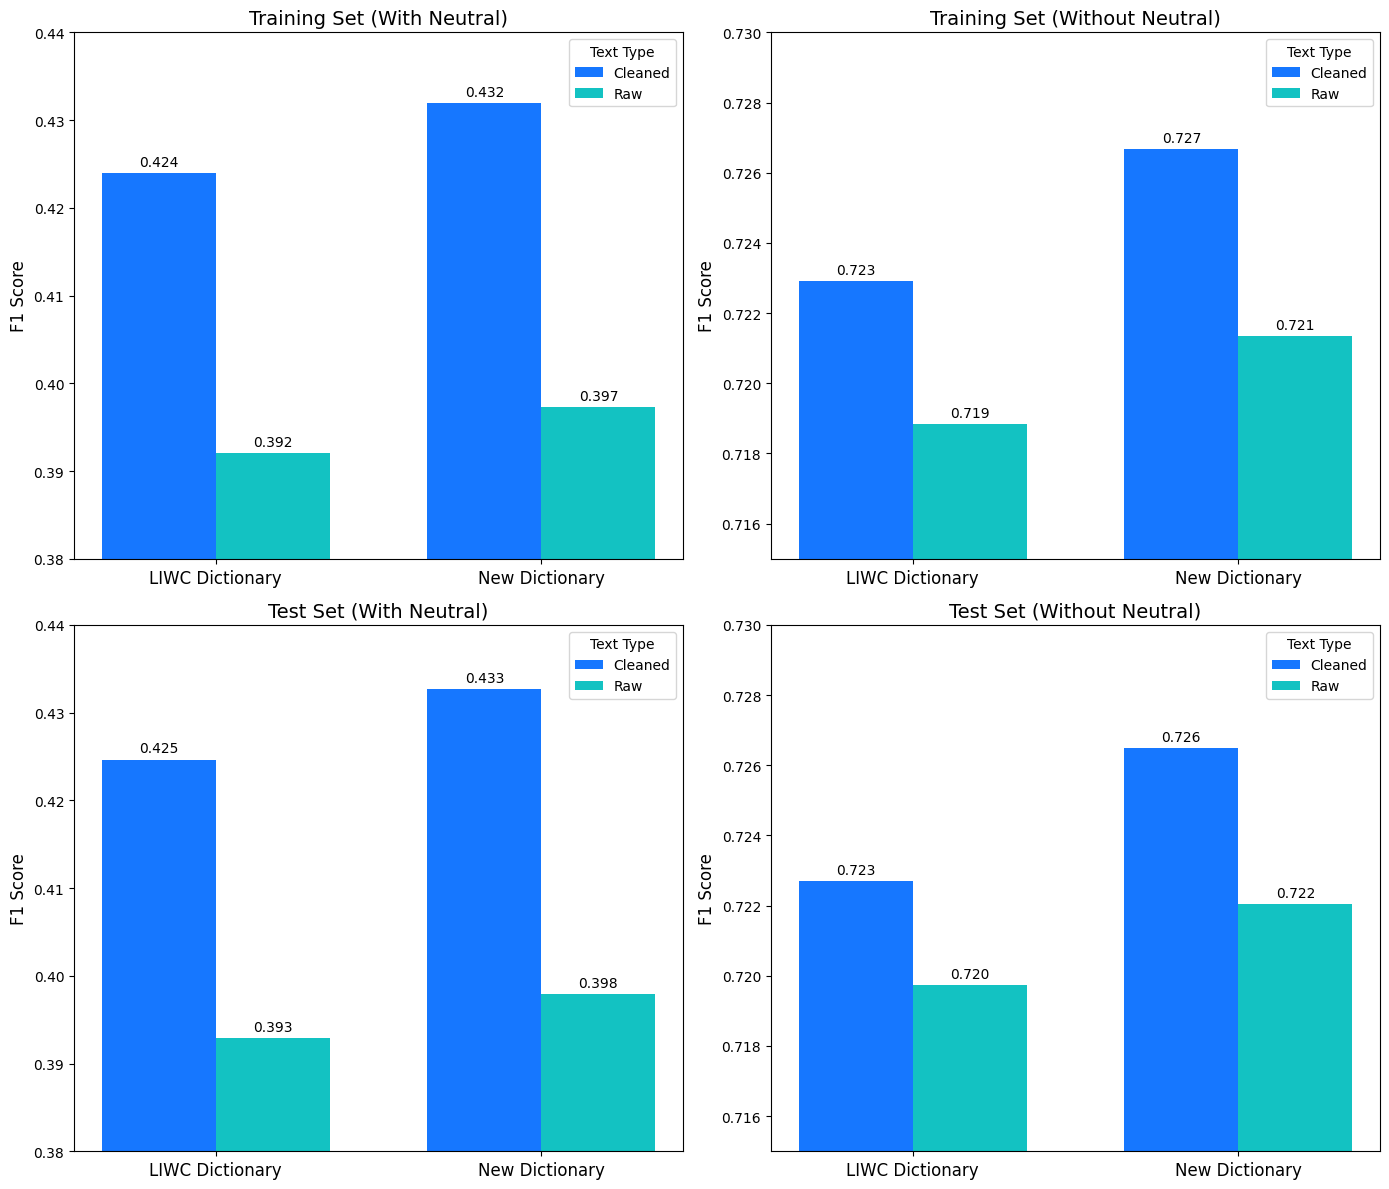

In [41]:
## Visualization -------------
# For each dataset and evaluation metric, we have two values per dictionary type:
# [Cleaned, Raw]
# Training set
train_scores_with = {
    'LIWC Dictionary': [res_clean_liwcdict['F1 Score with None/Neutral'], res_raw_liwcdict['F1 Score with None/Neutral']],
    'New Dictionary': [res_clean_newdict['F1 Score with None/Neutral'], res_raw_newdict['F1 Score with None/Neutral']]
}
train_scores_without = {
    'LIWC Dictionary': [res_clean_liwcdict['F1 Score without None/Neutral'], res_raw_liwcdict['F1 Score without None/Neutral']],
    'New Dictionary': [res_clean_newdict['F1 Score without None/Neutral'], res_raw_newdict['F1 Score without None/Neutral']]
}
# Test set
test_scores_with = {
    'LIWC Dictionary': [res_test_clean_liwcdict['F1 Score with None/Neutral'], res_test_raw_liwcdict['F1 Score with None/Neutral']],
    'New Dictionary': [res_test_clean_newdict['F1 Score with None/Neutral'], res_test_raw_newdict['F1 Score with None/Neutral']]
}
test_scores_without = {
    'LIWC Dictionary': [res_test_clean_liwcdict['F1 Score without None/Neutral'], res_test_raw_liwcdict['F1 Score without None/Neutral']],
    'New Dictionary': [res_test_clean_newdict['F1 Score without None/Neutral'], res_test_raw_newdict['F1 Score without None/Neutral']]
}

# Define dictionary types and text types.
dict_types = list(train_scores_with.keys())  # ['New Dictionary', 'LIWC Dictionary']
text_types = ['Cleaned', 'Raw']

# Plotting Functions
def plot_scores(ax, scores, title):
    """
    Plots a grouped bar chart on the provided axis.
    """
    x = np.arange(len(dict_types))
    width = 0.35  # width of each bar
    offsets = [-width/2, width/2]  # offsets for the two text types
    colors = ['#1677ff', '#13c2c2']
    
    for i, text_type in enumerate(text_types):
        vals = [scores[d][i] for d in dict_types]
        ax.bar(x + offsets[i], vals, width, label=text_type, color=colors[i])
    
    ax.set_xticks(x)
    ax.set_xticklabels(dict_types, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.legend(title='Text Type', fontsize=10)

def autolabel(ax):
    """
    Attach a text label above each bar displaying its height.
    """
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset in points
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)


# Create a 2x2 Grid of Subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=False)

# Top Row: Training Set
plot_scores(axes[0, 0], train_scores_with, 'Training Set (With Neutral)')
plot_scores(axes[0, 1], train_scores_without, 'Training Set (Without Neutral)')

# Bottom Row: Test Set
plot_scores(axes[1, 0], test_scores_with, 'Test Set (With Neutral)')
plot_scores(axes[1, 1], test_scores_without, 'Test Set (Without Neutral)')

# Set y-axis limits to zoom in on the differences.
# For "With Neutral" plots: values ~0.39 to ~0.43 → use a slightly wider range.
axes[0, 0].set_ylim(0.38, 0.44)
axes[1, 0].set_ylim(0.38, 0.44)
# For "Without Neutral" plots: values ~0.718 to ~0.727 → use a tighter range.
axes[0, 1].set_ylim(0.715, 0.73)
axes[1, 1].set_ylim(0.715, 0.73)

# Annotate all bars with their values.
for ax in axes.flatten():
    autolabel(ax)

plt.tight_layout()
plt.show()

##### Interpretation

=== The Probability of response "Neutral" ===
| **Train** |  LIWC  | Expanded |   | **Test** |  LIWC  | Expanded |
|-----------|:------:|:--------:|---|----------|:------:|:--------:|
| Raw       | .6239  |  .6187   |   | Raw      | .6235  |  .6184   |
| Clean     | .5836  | **.5754**|   | Clean    | .5824  |**.5743** |

The expanded dictionary approach demonstrated better performance, validating the effectiveness of integrating manual and Word2Vec-based expansions. 

**Neutral Probability**

The relatively high probability of the "Neutral" category occurs primarily because the dictionary method can fail to detect emotional expressions if none of the predefined emotional words appear in a tweet. I use a quite strict criteria for "neutral" that only the sentiment score was exactly zero, meaning no emotional words were matched. Since the dataset exclusively contains positive and negative sentiments, ideally, there should be very few neutral classifications. The high neutral rate thus indicates limitations in the dictionary’s coverage of emotional vocabulary. 
- Text Cleaning significantly improved emotional expression detection for dictionary: from approximately 62% (raw text) to about 58% (cleaned text) on the both dataset. Again, text preprocessing is important for downstream tasks.
- Expanding the dictionary (based on Word2Vec similarity) also slightly improved the emotional expression detection by decreasing 1%: I use the Word2Vec to search the similar expression in the corpus which enhance the detection ability in certain context. However, as I just expand the dictionary for several rounds which is still away from saturation. More elaboration will reduce the probability of "Neutral" classification.

**F1-Score**

I calculate two types of F1-Score, both of them support the main findings: **(1) The expanded dictionary approach demonstrated better performance; (2) The text preprocessing could significantly improve the performance of downstream tasks.**
- F1 Score without Neutral: Represents how accurately the dictionary classifies tweets when emotional words are detected. Higher scores (around 0.72-0.73) demonstrate that the dictionary can reliably classify tweets as positive or negative when it successfully identifies emotional expressions.
- F1 Score with Neutral: Considers neutral predictions as errors, resulting in a lower score (around 0.40-0.43). This emphasizes the importance of minimizing neutral classifications by further refining and expanding the dictionary to better detect emotional expressions.

### 4. Supervised Machine Learning

After the dictionary-based approach, a supervised machine learning model leverages labeled examples (the training dataset) to learn predictive patterns directly from data.

##### Implementation and Hyperparameter Tuning

**Data Splits**
- Feature Representations: TF-IDF Document-Term Matrices for training (`X_train`) and testing (`X_test`).

**Model Selection**
- Naive Bayes (MultinomialNB): A fast, probabilistic classifier assuming feature independence.
- Random Forest: An ensemble of decision trees, capturing more complex relationships in the data.

**Hyperparameter Tuning**
- Performed 10-fold cross-validation (`GridSearchCV`) on the training set for both models.
- Explored different parameter grids, focusing on:
    - MultinomialNB: `Alpha` (smoothing factor), `fit_prior` (whether to learn class priors), and `class_prior` (manually set priors).
    - RandomForestClassifier: `n_estimators` (Number of estimators) and `max_depth` (tree depth).

##### Evaluation
Reported precision, recall, and F1-scores on both training and test sets using `classification_report`.

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [42]:
# 10-fold cross-validation
def fine_tune_hyperparameters(model, search_params, X_train, y_train):
    """
    Fine-tune the hyperparameters of the model using GridSearchCV.
    """
    grid_search = GridSearchCV(model, search_params, cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    return grid_search.best_estimator_

def evaluate_model(model, X, y, title=""):
    """
    Evaluate the model using the classification report.
    """
    y_pred = model.predict(X)

    if title:
        print(f"{title} Classification Report:")
        print(classification_report(y, y_pred, target_names=['Negative', 'Positive'], digits=4))
    else:
        print("Classification Report:")
        print(classification_report(y, y_pred, target_names=['Negative', 'Positive'], digits=4))

In [43]:
# Split the data into training and test sets
X_train = dtm
y_train = raw_corpus['target']
X_test = dtm_test
y_test = test_corpus['target']
# Convert the target variable to numeric
y_train = y_train.replace({0: 0, 4: 1})
y_test = y_test.replace({0: 0, 4: 1})

In [46]:
## Model 1: Naive Bayes (MultinomialNB)
# Tune hyperparameters for MultinomialNB
print("Tuning MultinomialNB hyperparameters...")
nb_model = MultinomialNB()
nb_search_params = {
    # 'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], # Best parameter found: 10 in the previous run
    'alpha': range(1, 20, 1),
    'fit_prior': [True, False],
    'class_prior': [None, [0.5, 0.5]]
}

nb_model = fine_tune_hyperparameters(nb_model, nb_search_params, X_train, y_train)

# Save the tuned Naive Bayes model.
with open('./pickle/nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

# # Load the model
# with open('./pickle/nb_model.pkl', 'rb') as f:
#     nb_model = pickle.load(f)

Tuning MultinomialNB hyperparameters...
Best parameters found:  {'alpha': 19, 'class_prior': None, 'fit_prior': True}


In [49]:
## Model 2: Random Forest Classifier
print("Tuning Random Forest hyperparameters...")

rf_model = RandomForestClassifier(random_state=42)
rf_search_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
}

rf_model = fine_tune_hyperparameters(rf_model, rf_search_params, X_train, y_train)

# Save the tuned Random Forest model.
with open('./pickle/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

Tuning Random Forest hyperparameters...
Best parameters found:  {'max_depth': 20, 'n_estimators': 200}


In [52]:
# Evaluate the Naive Bayes model on both training and test sets.
evaluate_model(nb_model, X_train, y_train, title="Training Set (Naive Bayes)")
evaluate_model(nb_model, X_test, y_test, title="Test Set (Naive Bayes)")

Training Set (Naive Bayes) Classification Report:
              precision    recall  f1-score   support

    Negative     0.7545    0.7011    0.7268    639973
    Positive     0.7209    0.7719    0.7455    640050

    accuracy                         0.7365   1280023
   macro avg     0.7377    0.7365    0.7361   1280023
weighted avg     0.7377    0.7365    0.7361   1280023

Test Set (Naive Bayes) Classification Report:
              precision    recall  f1-score   support

    Negative     0.7526    0.6999    0.7253    160027
    Positive     0.7194    0.7698    0.7438    159950

    accuracy                         0.7349    319977
   macro avg     0.7360    0.7349    0.7345    319977
weighted avg     0.7360    0.7349    0.7345    319977



In [53]:
# Evaluate the Random Forest model on both training and test sets.
evaluate_model(rf_model, X_train, y_train, title="Training Set (Random Forest)")
evaluate_model(rf_model, X_test, y_test, title="Test Set (Random Forest)")

Training Set (Random Forest) Classification Report:
              precision    recall  f1-score   support

    Negative     0.7903    0.5248    0.6307    639973
    Positive     0.6443    0.8608    0.7370    640050

    accuracy                         0.6928   1280023
   macro avg     0.7173    0.6928    0.6839   1280023
weighted avg     0.7173    0.6928    0.6839   1280023

Test Set (Random Forest) Classification Report:
              precision    recall  f1-score   support

    Negative     0.7834    0.5221    0.6266    160027
    Positive     0.6415    0.8556    0.7333    159950

    accuracy                         0.6888    319977
   macro avg     0.7125    0.6889    0.6799    319977
weighted avg     0.7125    0.6888    0.6799    319977



##### Interpretation

Overall, Naive Bayes outperforms Random Forest across all metrics, suggesting simpler models may be better suited for this task with TF-IDF features.

For specific classification, Naive Bayes achieves better balance between precision/recall while Random Forest shows extreme asymmetry - high negative precision but poor recall, and vice versa for positives.

For Comparison between two models. Naive Bayes performs better might because TF-IDF matrices  align well with Naive Bayes’ assumption of conditional independence between features. Additionally, the tree-based method maybe not the good choice for managing high-dimensional sparse text data. Also, I tune only two parameters (n_estimators, max_depth) and both of them suggest more complex tree-structure in parameters tuning, which would not sufficiently capture interactions in TF-IDF features.

### 5. GPT

In this module, I used the ChatGPT to conduct the sentiment analysis. To preserve sentence coherence and cohesion, which can be disrupted by text preprocessing, I leveraged ChatGPT’s advanced natural language processing capabilities to analyze raw text directly. This approach ensures maximum retention of contextual information.

##### Experiments

**Prompt Engineering**
- Vanilla Prompt: A straightforward instruction to respond only with "Positive" or "Negative."
- Few-Shot Prompt: Includes examples illustrating the classification of sample tweets.

Notably, while some studies suggest that zero-shot learning may outperform few-shot approaches in certain complex text analysis tasks—potentially due to insufficient or low-quality examples confusing the model and degrading performance—I intentionally designed a few-shot strategy. My examples included `"I love this product! :)"` → Positive and `"I hate this product! :("` → Negative. This decision stemmed from preliminary analysis revealing a high frequency of emoticons in the dataset. By explicitly incorporating emoticons into the examples, I aimed to direct the model’s attention to these contextual cues and improve its sensitivity to their semantic impact.

**Temperature Variations**
- temperature=0.7: some creativity
- temperature=0.3: more deterministic and consistent responses.

**Model Variations**
- gpt-4o
- gpt-4o-mini: smaller

**Evaluation**
- Sampled 1,000 tweets* from the test corpus, preserving the original distribution of Positive and Negative. Used the same `evaluate_with_nonresponse` function as before

*For efficiency in both resource allocation (API costs) and time management, I employed a random sampling strategy, selecting 1,000 entries from the test dataset of approximately 320,000 records. The sampled data exhibited a label distribution closely aligned with the original dataset (52.7% Negative + 47.3% Positive) . Additionally, rather than conducting factorial experiments (e.g., 2x2x2 designs) to evaluate combinations of prompts, temperature settings, and model versions, I performed sequential testing to streamline the process and reduce overhead.

In [54]:
from openai import AzureOpenAI

In [ ]:
# Parameters
client = AzureOpenAI(
  azure_endpoint = "https://hkust.azure-api.net",
  api_version = "2024-06-01",
  api_key = "" #put your api key here
)

In [14]:
vanilla_prompt = """
Analyze the sentiment of the following text. Respond using only one of these exact words: Positive, Negative. Do not include any explanation or additional words, no punctuation.
"""

fewshot_prompt = """
Analyze the sentiment of the following text. Respond using only one of these exact words: Positive, Negative. Do not include any explanation or additional words, no punctuation. 
Example: "I love this product! :) " -> Positive, "I hate this product! :(" -> Negative
"""

In [15]:
def get_response(message, instruction = vanilla_prompt, model='gpt-4o', temperature=0.7, max_try = 3):
    """"
    "Get the response from the model."
    """
    for _ in range(max_try):
        try:
            # Call the model
            response = client.chat.completions.create(
                model = model,
                temperature = temperature,
                messages = [
                    {"role": "system", "content": instruction},
                    {"role": "user", "content": message}
                ]
            )
            # Check if the response is valid 
            if "Positive" in response.choices[0].message.content:
                return "Positive"
            elif "Negative" in response.choices[0].message.content:
                return "Negative"
            else:
                # If the response is not valid, try again
                continue
        except:
            continue
    # If the response is not valid after max_try times, return None
    return None

In [ ]:
# For the sake of cost and time, I only sample 1000 tweets from the test corpus
df_gpt_sample = test_corpus[['target','text']].sample(1000, random_state=42).copy()
df_gpt_sample['target'] = df_gpt_sample['target'].replace({0: "Negative", 4: "Positive"})
df_gpt_sample['target'].value_counts()

target
0    527
1    473
Name: count, dtype: int64

In [56]:
# Load the results
df_gpt_sample = pd.read_csv('./data/gpt_results.csv')

In [ ]:
# Different prompts
# df_gpt_sample['4o_vanilla_7'] = df_gpt_sample['text'].apply(get_response, instruction=vanilla_prompt, model='gpt-4o', temperature=0.7)
# df_gpt_sample['4o_fewshot_7'] = df_gpt_sample['text'].apply(get_response, instruction=fewshot_prompt, model='gpt-4o', temperature=0.7)

# df_gpt_sample['4o_vanilla_7'].fillna("NAN", inplace=True)
# df_gpt_sample['4o_fewshot_7'].fillna("NAN", inplace=True)

In [59]:
# Results - Different prompts
print("Classification Report of Vanilla Prompts:")
print(evaluate_with_nonresponse(df_gpt_sample, target_col='target', pred_col='4o_vanilla_7', non_maker='NAN'))
print("Classification Report of Fewshot Prompts:")
print(evaluate_with_nonresponse(df_gpt_sample, target_col='target', pred_col='4o_fewshot_7', non_maker='NAN'))

Classification Report of Vanilla Prompts:
{'None Probability': 0.017, 'F1 Score without None/Neutral': 0.7882900778682012, 'F1 Score with None/Neutral': 0.7814541233035742}
Classification Report of Fewshot Prompts:
{'None Probability': 0.016, 'F1 Score without None/Neutral': 0.7892671674862181, 'F1 Score with None/Neutral': 0.7827891760373511}


In [60]:
# # Different temperature
# df_gpt_sample['4o_fewshot_3'] = df_gpt_sample['text'].apply(get_response, instruction=fewshot_prompt, model='gpt-4o', temperature=0.3)
# df_gpt_sample['4o_fewshot_3'].fillna("NAN", inplace=True)

# Results - Different temperature
print("Classification Report of Fewshots Prompts with Temperature 0.3:")
print(evaluate_with_nonresponse(df_gpt_sample, target_col='target', pred_col='4o_fewshot_3', non_maker='NAN'))

Classification Report of Fewshots Prompts with Temperature 0.3:
{'None Probability': 0.02, 'F1 Score without None/Neutral': 0.8039141350317613, 'F1 Score with None/Neutral': 0.795542628665459}


In [61]:
# # Different models
# df_gpt_sample['4omini_fewshot_7'] = df_gpt_sample['text'].apply(get_response, instruction=fewshot_prompt, model='gpt-4o-mini', temperature=0.7)
# df_gpt_sample['4omini_fewshot_7'].fillna("NAN", inplace=True)

# Results - Different models
print("Classification Report of Fewshot Prompts with Mini Model:")
print(evaluate_with_nonresponse(df_gpt_sample, target_col='target', pred_col='4omini_fewshot_7', non_maker='NAN'))

Classification Report of Fewshot Prompts with Mini Model:
{'None Probability': 0.02, 'F1 Score without None/Neutral': 0.7816926817789631, 'F1 Score with None/Neutral': 0.7737365830467908}


In [ ]:
# # Save the results
# df_gpt_sample.to_csv('./data/gpt_results.csv', index=False)

##### Interpretation

| Configuration        | None Probability | F1 (Excl. None) | F1 (Incl. None) |
|----------------------|:----------------:|:---------------:|:---------------:|
| Vanilla Prompts      |       1.7%       |      0.788      |      0.781      |
| Fewshot Prompts      |       1.6%       |      0.789      |      0.783      |
| Fewshot + Temp 0.3   |       2.0%       |    **0.804**    |    **0.796**    |
| Fewshot + Mini Model |       2.0%       |      0.782      |      0.774      |

None Probability (Unclassified Responses):
- All configurations show low "None" rates (1.6–2.0%), indicating ChatGPT generally adheres to the required response format.
- The slight increase in "None" for Temperature 0.3 and Smaller model (2.0%) suggests:
    - Lower temperature may reduce response variability, increasing strict adherence (or rigidity).
    - Smaller models (gpt40-mini) may struggle with ambiguous or neutral text.

Performance Trends (F1 Scores):
- Fewshot + Temperature 0.3 performs best:
    - F1 = 0.804 (excluding None) and 0.796 (including None).
    - Lower temperature (0.3) likely stabilizes outputs, reducing randomness and improving consistency.
- Vanilla vs. Fewshot Prompts:
    - Fewshot marginally outperforms vanilla prompts (F1 ~0.789 vs. 0.788).
    - My emoticon-focused examples likely helped the model better recognize sentiment cues.
- Mini Model Limitations:
    - Lowest F1 scores (0.772–0.782) highlight reduced capability compared to larger models.

Impact of Including/Excluding None Responses:
- F1 consistently drops when treating "None" as false predictions (~0.005–0.01 decline).
- This gap reflects ambiguous cases where ChatGPT abstains from labeling (neutral or unclear text).

### 6. Topic Modeling

Topic modeling provides an unsupervised approach to discover latent themes in Tweets. Ideally, some topics would positive-dominant and some are mainly negative. So topic modeling could be used for sentiment analysis.

##### Initialization
I use the Latent Dirichlet Allocation (LDA) with `Gensim` to learn hidden topics. Use the tokenized corpus as documents, transformed into bag-of-words (dictionary, corpus), then fed into LDA.

##### Find optimal number of topics
To determine the optimal number of topics, I measure both coherence and exclusivity score for models. 
- Coherence indicates how semantically consistent a topic is. I use `c_v` as measurement. 
- Refer to `stm` package in R. I use the FRequent and EXclusivity (FREX) score to measure exclusivity, which balances high-frequency words and exclusivity of usage within each topic. 

Then I evaluate a range (from 3 to 15) based on these measurements. The optimal number of topics would be chosen by analyzing the trade-off between coherence and exclusivity.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from scipy.stats import rankdata

def compute_frex_scores(lda_model, dictionary, top_n_tokens=20, excl_weight=0.5):
    """
    Computes FREX scores for each topic in an LDA model.
    
    FREX (FREquency and EXclusivity) is a weighted harmonic combination of:
      - Frequency: how common the token is in the topic (raw beta values).
      - Exclusivity: how exclusive the token is to the topic relative to its usage in all topics.
      
    This function refer to https://rdrr.io/cran/topicdoc/src/R/topic_exclusivity.R
    """
    # Get the beta matrix: shape (num_topics, vocabulary_size)
    beta_mat = lda_model.get_topics()  # Each row sums to 1.
    num_topics, V = beta_mat.shape
    
    # Compute beta_normed: for each term (column), normalize across topics.
    col_sums = beta_mat.sum(axis=0)
    beta_normed = beta_mat / col_sums  # Shape: (num_topics, V)
    
    # Compute rank matrices for frequency and exclusivity.
    # For each topic (row), rankdata gives ranks where the highest probability gets rank = V.
    excls = np.zeros_like(beta_normed)
    freqs = np.zeros_like(beta_mat)
    for t in range(num_topics):
        excls[t, :] = rankdata(beta_normed[t, :], method='average')
        freqs[t, :] = rankdata(beta_mat[t, :], method='average')
    # Normalize ranks by dividing by V, so values are in (0, 1] with 1 = best.
    excls = excls / V
    freqs = freqs / V
    
    # For each topic, obtain the top_n_tokens (by raw beta probability)
    frex_scores = np.zeros(num_topics)
    for t in range(num_topics):
        # Get indices of the top tokens for topic t (highest probability words)
        top_indices = np.argsort(beta_mat[t, :])[::-1][:top_n_tokens]
        
        # Extract the exclusivity and frequency normalized ranks for these tokens
        topic_excls = excls[t, top_indices]
        topic_freqs = freqs[t, top_indices]
        
        # Compute the FREX score for each token:
        # For each token:
        #   score = 1 / ( (excl_weight / exclusivity_rank) + ((1 - excl_weight) / frequency_rank) )
        token_scores = 1.0 / ((excl_weight / topic_excls) + ((1 - excl_weight) / topic_freqs))
        # Sum token scores to get a FREX score for the topic.
        frex_scores[t] = token_scores.sum()
    
    return frex_scores

def topic_modeling_evaluation(docs, num_topics=10, top_n_tokens=20, passes=10, random_state=42, excl_weight=0.5):
    """
    Trains an LDA model and evaluates it using:
      - Coherence (semantic cohesiveness) via Gensim's CoherenceModel.
      - FREX scores (as a combined measure of frequency and exclusivity) computed via rank-based metrics.
    """
    # Create dictionary and corpus from preprocessed docs
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=random_state,
                         passes=passes)
    
    # Compute coherence using the 'c_v' measure
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=docs,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Compute FREX scores (which combine exclusivity and frequency aspects)
    frex_scores = compute_frex_scores(lda_model, dictionary, top_n_tokens=top_n_tokens, excl_weight=excl_weight)
    avg_frex = np.mean(frex_scores)
    
    return lda_model, coherence_score, avg_frex, frex_scores, dictionary, corpus

def evaluate_topic_range(docs, topic_range, top_n_tokens=20, passes=10, excl_weight=0.5):
    """
    Evaluates LDA models over a range of topic numbers and collects coherence and exclusivity scores.
    """
    coherence_scores = []
    avg_frex_scores = []
    
    for num_topics in topic_range:
        _, coherence_score, avg_frex, frex_scores, _, _ = topic_modeling_evaluation(
            docs, num_topics=num_topics, top_n_tokens=top_n_tokens, passes=passes, excl_weight=excl_weight)
        coherence_scores.append(coherence_score)
        avg_frex_scores.append(avg_frex)
        print(f"Num topics: {num_topics}, Coherence: {coherence_score:.4f}, Exclusivity: {avg_frex:.4f}")
    
    return coherence_scores, avg_frex_scores

In [64]:
# The docs must be tokenized and preprocessed
docs = test_corpus['cleaned_text'].str.split().tolist()

In [67]:
# Define the range of topics to evaluate
# topic_range = range(5, 100, 10) #
topic_range = range(3, 15, 1)

# Evaluate the models over the range of topics
coherence_scores, avg_frex_scores = evaluate_topic_range(docs, topic_range, top_n_tokens=20, passes=15)

Num topics: 3, Coherence: 0.3602, Avg FREX: 19.3286
Num topics: 4, Coherence: 0.3017, Avg FREX: 19.5380
Num topics: 5, Coherence: 0.3406, Avg FREX: 19.5556
Num topics: 6, Coherence: 0.3506, Avg FREX: 19.5257
Num topics: 7, Coherence: 0.3377, Avg FREX: 19.7095
Num topics: 8, Coherence: 0.3300, Avg FREX: 19.7582
Num topics: 9, Coherence: 0.3137, Avg FREX: 19.6833
Num topics: 10, Coherence: 0.3034, Avg FREX: 19.9843
Num topics: 11, Coherence: 0.2911, Avg FREX: 19.6512
Num topics: 12, Coherence: 0.2748, Avg FREX: 19.9952
Num topics: 13, Coherence: 0.2668, Avg FREX: 19.9964
Num topics: 14, Coherence: 0.2487, Avg FREX: 19.9283


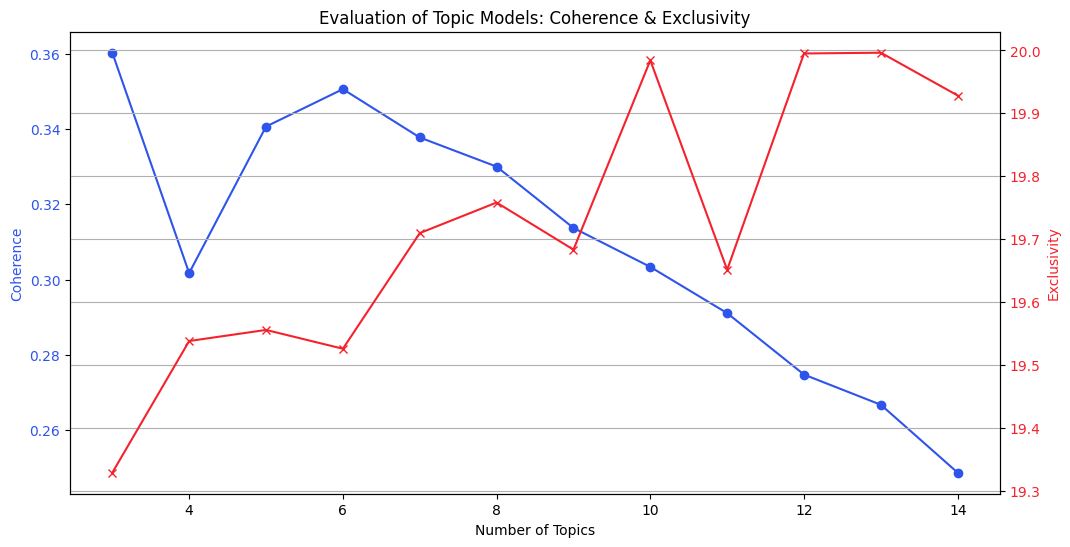

In [68]:
# Plot the evaluation metrics
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot coherence on the left y-axis
color = '#2f54eb'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=color)
ax1.plot(list(topic_range), coherence_scores, marker='o', color=color, label='Coherence')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for FREX scores
ax2 = ax1.twinx()
color = '#f5222d'
ax2.set_ylabel('Exclusivity', color=color)
ax2.plot(list(topic_range), avg_frex_scores, marker='x', color=color, label='Exclusivity')
ax2.tick_params(axis='y', labelcolor=color)

# Optionally, add a title and grid
plt.title('Evaluation of Topic Models: Coherence & Exclusivity')
plt.grid(True)
plt.show()

According to the figure, I choose the 8 as the number of topics as it has relative high coherence and exclusivity at the same time. (Still hard to decide, just heuristic choose a reasoning one) 

##### Interpreting Topics

For each topic, I list top frequent words (high probability in that topic) and top FREX words (high frequency + exclusivity). This guides labeling.

Final labels are assigned based on domain knowledge and the top keywords.

In [69]:
def train_lda_model(docs, num_topics=10, passes=10, random_state=42):
    """
    Train an LDA model using gensim.
    """
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=random_state,
                         passes=passes)
    return lda_model, dictionary, corpus

def get_topic_words(lda_model, dictionary, top_n_tokens=10, excl_weight=0.5):
    """
    For each topic in the LDA model, compute and return both:
      - The top frequent words (based on raw topic-term probabilities).
      - The top FREX words (combining frequency and exclusivity).
    """
    # Get topic-term probability matrix (each row sums to 1)
    beta_mat = lda_model.get_topics()   # shape: (num_topics, vocabulary_size)
    num_topics, V = beta_mat.shape

    # Gensim dictionary: use id2token mapping for token lookup.
    vocab = dictionary.id2token

    # Compute normalized beta: for each term, what fraction of its total probability is in each topic.
    col_sums = beta_mat.sum(axis=0)
    beta_normed = beta_mat / col_sums  # shape: (num_topics, V)

    # For each topic, compute the rank of each token by:
    #   - Frequency: based on beta_mat (raw probability)
    #   - Exclusivity: based on beta_normed (how exclusive is the token to the topic)
    # Use rankdata so that the highest probability gets the highest rank.
    freq_ranks = np.zeros_like(beta_mat)
    excl_ranks = np.zeros_like(beta_normed)
    for t in range(num_topics):
        freq_ranks[t, :] = rankdata(beta_mat[t, :], method='average')
        excl_ranks[t, :] = rankdata(beta_normed[t, :], method='average')
    # Normalize ranks to (0, 1] by dividing by the vocabulary size V.
    freq_ranks = freq_ranks / V
    excl_ranks = excl_ranks / V

    topic_results = {}
    for t in range(num_topics):
        # Top frequent words: sort tokens by raw probability in descending order.
        top_freq_indices = np.argsort(beta_mat[t, :])[::-1][:top_n_tokens]
        frequent_words = [(vocab[i], beta_mat[t, i]) for i in top_freq_indices]

        # For each token, compute FREX score.
        # Note: higher FREX indicates a better balance of frequency and exclusivity.
        token_frex = 1.0 / ((excl_weight / excl_ranks[t, :]) + ((1 - excl_weight) / freq_ranks[t, :]))
        # Sort tokens by FREX score (descending) and take the top ones.
        top_frex_indices = np.argsort(token_frex)[::-1][:top_n_tokens]
        frex_words = [(vocab[i], token_frex[i]) for i in top_frex_indices]

        topic_results[t] = {"frequent_words": frequent_words, "frex_words": frex_words}
    
    return topic_results

def print_topic_words(lda_model, dictionary, top_n_tokens=10, excl_weight=0.5):
    """
    Print for each topic the top frequent words and the top FREX words.
    """
    results = get_topic_words(lda_model, dictionary, top_n_tokens=top_n_tokens, excl_weight=excl_weight)

    outlines = []
    for t, data in results.items():
        print(f"Topic {t}:")
        # Construct a single line for frequent words
        frequent_line = "  Most frequent words: " + ", ".join([
            f"{word}({score:.4f})" for word, score in data["frequent_words"]
        ])
        # Construct a single line for FREX words
        frex_line = "  Most FREX words: " + ", ".join([
            f"{word}({score:.4f})" for word, score in data["frex_words"]
        ])
        print(frequent_line)  # Most frequent words line
        print(frex_line)      # Most FREX words line
        print()               # Spacing

        outlines.extend([f"Topic {t}:", frequent_line, frex_line, ""])

    with open('./topic_words.txt', 'w') as f:
        f.write("\n".join(outlines))
    print('Topic words saved to "topic_words.txt')

In [70]:
# Train a common LDA model with your chosen optimal number of topics (say, 5 topics)
lda_model, dictionary, corpus = train_lda_model(docs, num_topics=8, passes=15)

# Print the top frequent and FREX words for each topic.
print_topic_words(lda_model, dictionary, top_n_tokens=10, excl_weight=0.5)

Topic 0:
  Most frequent words: dont(0.0296), yeah(0.0276), song(0.0207), add(0.0146), free(0.0134), listening(0.0134), stuff(0.0120), music(0.0117), funny(0.0113), haha(0.0113)
  Most FREX words: yeah(1.0000), song(1.0000), add(1.0000), free(1.0000), listening(1.0000), stuff(1.0000), music(0.9999), funny(0.9999), aww(0.9999), vip(0.9999)

Topic 1:
  Most frequent words: great(0.0474), happy(0.0417), day(0.0217), birthday(0.0172), check(0.0126), today(0.0125), time(0.0113), house(0.0110), coming(0.0107), party(0.0102)
  Most FREX words: great(1.0000), happy(1.0000), birthday(1.0000), check(1.0000), house(1.0000), coming(0.9999), party(0.9999), job(0.9999), sunday(0.9999), eating(0.9999)

Topic 2:
  Most frequent words: twitter(0.0412), haha(0.0364), tweet(0.0216), follower(0.0175), follow(0.0175), people(0.0142), dont(0.0140), pic(0.0135), ive(0.0108), phone(0.0097)
  Most FREX words: twitter(1.0000), tweet(1.0000), follower(1.0000), follow(1.0000), pic(1.0000), phone(0.9999), picture(

##### Result of Topic Modeling

|         |     Label     |                         Description                         | Example Words (Selected Most Popular Words) |
|:-------:|:-------------:|:-----------------------------------------------------------:|:-------------------------------------------:|
| Topic 0 |     Music     | Maybe focuses on sharing music and chill content            | yeah, song, free, listening, music, funny   |
| Topic 1 |     Party     | Maybe focuses on parties and daily life                     | great, happy, birthday, house, party        |
| Topic 2 |  Social Media | Maybe focuses on social media interaction                   | twitter, tweet, follower, pic, fan          |
| Topic 3 |     Noise     | I prefer this topic is noise (failed identification)        | â, ã, laugh,loud,¢                          |
| Topic 4 |   Daily Life  | Maybe focuses on daily life and well-being                  | work, morning, ill, tomorrow, luck          |
| Topic 5 |  Friendships  | Maybe focuses on friendships                                | friend, movie, ya, summer, cute             |
| Topic 6 | Entertainment | Maybe focuses on enthusiastic entertainment and food        | amazing, excited, working, game, dinner     |
| Topic 7 |  Affirmations | Maybe mainly contains compliments and reflective expression | awesome, sweet, beautiful, talk, album      |

First, despite noise in the data, topic modeling demonstrates an ability to categorize and identify noisy patterns effectively. 

Second, regarding topic sentiment, most topics lean toward positivity, with observable negative expressions primarily confined to the "Daily Life" category (though this topic still includes positive elements). Certain topics, such as "Social Media Interaction," appear neutral or lack clear emotional labels. 

Overall, relying solely on these topic modeling results for sentiment analysis risks overestimating positivity, even though the dataset itself contains a higher proportion of negative expressions. This highlights a potential mismatch between topic-based interpretations and the actual emotional distribution in the data.

##### Mapping Topics to Sentiment

After labeling each topic, we connect them to likely sentiments (positive, negative, or unknown) to approximate sentiment from topic membership.

Documents are assigned a dominant topic via the highest topic probability.

In [72]:
# Use topics to predict sentiment

# Assign dominant topic to each document
def assign_dominant_topic(lda_model, corpus):
    """
    Assigns a dominant topic to each document in the corpus based on the highest topic probability.
    """
    dominant_topics = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        if topics:
            dominant_topic = max(topics, key=lambda x: x[1])[0]
            dominant_topics.append(dominant_topic)
        else:
            dominant_topics.append(None)
    return dominant_topics

In [ ]:
df_topic_modeling = test_corpus[['target','text']].copy()
df_topic_modeling['target'] = df_topic_modeling['target'].replace({0: 'Negative', 4: 'Positive'})

# Assign dominant topics to the test corpus
dominant_topics = assign_dominant_topic(lda_model, corpus)

df_topic_modeling['dominant_topic'] = dominant_topics
# Label the dominant topics
df_topic_modeling['dominant_topic'] = df_topic_modeling['dominant_topic'].replace(
    {0: 'Music', 1: 'Party', 2: 'Social Media', 3: 'Noise', 4: 'Daily Life', 5: 'Friendship', 6: 'Entertainment', 7: 'Affirmations'}
    )

# Map the dominant topics to sentiment labels
topic_sentiment_map = {
    'Music': "Positive",
    'Party': "Positive", 
    'Social Media': "NAN", 
    'Noise': "Positive", # I still consider this topic as "Positive" because "laugh", "hahah" are its keywords
    'Daily Life': "Positive",
    'Friendship': "Positive", 
    'Entertainment': "Positive", 
    'Affirmations': "Positive"
}

# Map the dominant topics to sentiment labels
df_topic_modeling['predicted_sentiment'] = df_topic_modeling['dominant_topic'].map(topic_sentiment_map)

In [ ]:
# Results - Topic Modeling
print("Classification Report of Topic Modeling for sentiment analysis:")
print(evaluate_with_nonresponse(df_topic_modeling, target_col='target', pred_col='predicted_sentiment', non_maker='NAN'))

Classification Report of Topic Modeling for sentiment analysis:
{'None Probability': 0.12289320794932136, 'F1 Score without None/Neutral': 0.3343910826514882, 'F1 Score with None/Neutral': 0.3200061733438644}


In [82]:
# The proportion of Positive and Negative under each topic
for topic in topic_sentiment_map.keys():
    topic_df = df_topic_modeling[df_topic_modeling['dominant_topic'] == topic]
    # Calculate the proportions of Positive and Negative
    counts = topic_df['target'].value_counts(normalize=True)
    
    # Safely retrieve each proportion (defaulting to 0 if not found)
    neg_prop = counts.get('Negative', 0.0)
    pos_prop = counts.get('Positive', 0.0)
    
    print(f"Topic {topic}: Negative={neg_prop:.4f}, Positive={pos_prop:.4f}")

Topic Music: Negative=0.4671, Positive=0.5329
Topic Party: Negative=0.4743, Positive=0.5257
Topic Social Media: Negative=0.5180, Positive=0.4820
Topic Noise: Negative=0.4469, Positive=0.5531
Topic Daily Life: Negative=0.5420, Positive=0.4580
Topic Friendship: Negative=0.5165, Positive=0.4835
Topic Entertainment: Negative=0.4621, Positive=0.5379
Topic Affirmations: Negative=0.5145, Positive=0.4855


The proportion of Positive and Negative under each topic suggested that it is hard to identify the sentiment solely by topic modeling. (The proportions of positive and negative are quite balanced) 

### 7. Discussion

Having already addressed the deployment processes and internal comparisons of each model or method in detail throughout earlier sections, I will now present a holistic comparative analysis of the methodologies as a whole. For each method, I choose the model with the best performance (on test dataset). However, per previous results of within-group comparison, there are no big differences between models within the group.

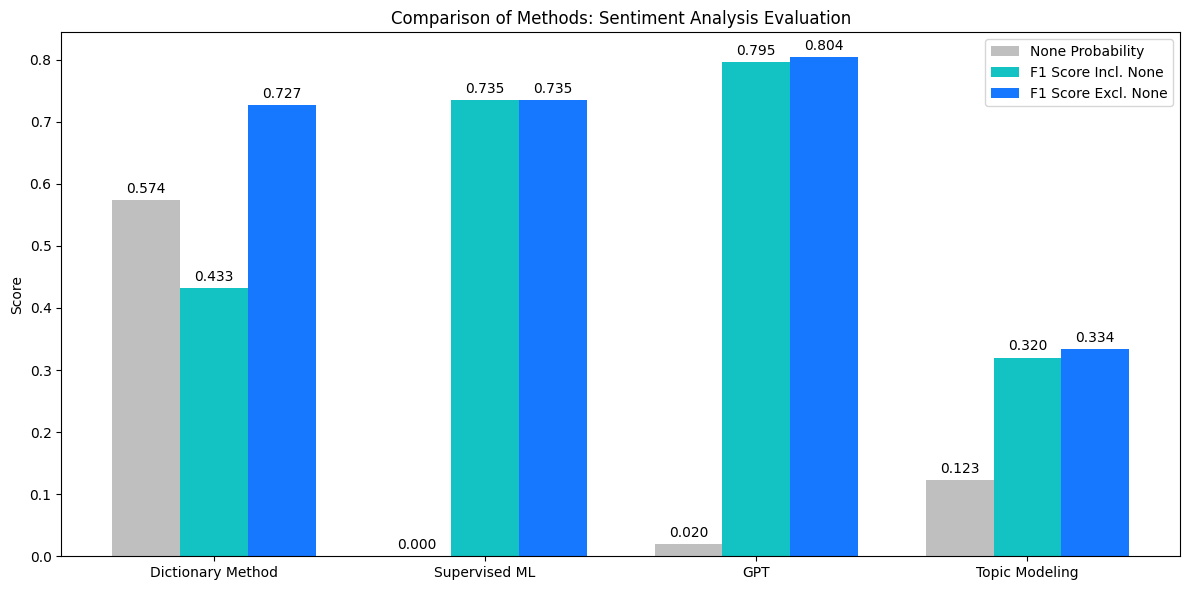

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Define methods and their respective metric values.
methods = ["Dictionary Method", "Supervised ML", "GPT", "Topic Modeling"]

# Metric values for each method.
none_prob = [0.5742, 0, 0.02, 0.1229]
f1_with = [0.4327, 0.7345, 0.7955, 0.3200]
f1_without = [0.7265, 0.7345, 0.8039, 0.3344]

# Set positions for groups and bar width.
x = np.arange(len(methods))
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each metric as a group of bars with an offset.
bars_none = ax.bar(x - width, none_prob, width, label="None Probability", color="#bfbfbf")
bars_f1_with = ax.bar(x, f1_with, width, label="F1 Score Incl. None", color="#13c2c2")
bars_f1_without = ax.bar(x + width, f1_without, width, label="F1 Score Excl. None", color="#1677ff")

# Add labels and title.
ax.set_ylabel("Score")
ax.set_title("Comparison of Methods: Sentiment Analysis Evaluation")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# Function to annotate bars with their height.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Annotate each set of bars.
autolabel(bars_none)
autolabel(bars_f1_with)
autolabel(bars_f1_without)

plt.tight_layout()
plt.show()

##### Performance & Flexibility
Dictionary Methods:
- Despite its high "None/Neutral" assignment rate (57.4%), it achieves a reasonable F1 score (72.6%) for non-neutral texts, indicating partial effectiveness in polarized sentiment detection and it is still one of the most valuable text analysis methods in social science. 
- Its performance plummets (F1 drop ~0.3, only observed in dictionary methods) when including neutral cases, primarily due to limited adaptability to informal social media language (e.g., slang, informal expression).
- Enhancing the base dictionary (e.g., LIWC) with social media-specific lexicons (e.g., emoji sentiment mappings, abbreviations) and contextual rules could mitigate false neutrality assignments.
- Retains importance in social science research due to high interpretability and suitability for hypothesis-driven analysis.

Supervised Machine Learning:
- Achieves moderate F1 (73.45%) with forces binary classification (ignoring neutrality), suggests its ability in text analysis.
- This method is quite suitable for binary classification.

GPT:
- Dominates with the highest F1 (~80%) and minimal "None" assignments (2%), demonstrating robust generalization across contexts. Its "plug-and-play" flexibility (via prompt engineering) allows rapid adaptation to new domains (e.g., sarcasm detection) without retraining, though API costs scale with data volume.

Topic Modeling:
- Fails as a standalone sentiment tool (F1 ~33%) due to thematic-emotional decoupling. Topics (e.g., "Social Media Interactions") and sentiment are almost orthogonal dimensions, requiring hybrid approaches (e.g., topic-guided sentiment analysis) for meaningful insights.

##### Deployment and Cost
Dictionary Methods: 
- Fully transparent rules
- Cost: Low computational needs but high manual effort to update lexicons for informal language.

Supervised Machine Learning:
- Limited to simpler models like logistic regression (in text analysis); neural networks are black-box
- Cost: Requires labeled data and computational resources for training

GPT:
- Opaque decision-making; sensitive to prompts
- Cost: API costs scale with usage (annotation for 1,000 rows ~ 2HKD and 18 mins); but no training needed

Topic Modeling:
- Thematic clusters are clear
- No direct sentiment logic, actually, cannot control the logic or scale to identify topics
- Cost: Unsupervised; minimal setup after parameter tuning


##### Other Limitations
Dictionary Methods: 
- Struggle with linguistic evolution (e.g., new slang) and context-dependent sentiments.

GPT: 
- Potential Bias (e.g., analyze the emotion expression of minority).

Topic Modeling: 
- Thematic clusters may not align with emotional labels (e.g., a "Celebrations" topic could mix both positive and negative tweets about holidays).